In [ ]:
import numpy as np

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [177]:
seed = 99
save_plot = True

In [178]:
np.random.seed(seed)

cases = generate_cases(40)
results = evaluate_cases(cases)
[(r.score, float(r.min_alt)) for r in results if not r.simulation_failed]

Error evaluating cases: velocity (3820.4841709011253) out of bounds
Error evaluating cases: alpha (-2.8212462835343413) out of bounds
Error evaluating cases: alpha (2.0215620532419125) out of bounds
Error evaluating cases: alpha (-25.82155313208543) out of bounds
Error evaluating cases: alpha (-2.8680569114910615) out of bounds
Error evaluating cases: alpha (3.129880467272257) out of bounds
Error evaluating cases: velocity (3019.244600993691) out of bounds
Error evaluating cases: alpha (2.301782691362485) out of bounds
Error evaluating cases: alpha (2.098526921266582) out of bounds
Error evaluating cases: velocity (159.1118565692932) out of bounds
Error evaluating cases: velocity (3363.2678617968395) out of bounds
Error evaluating cases: velocity (189.8173453803747) out of bounds
Error evaluating cases: alpha (-11.996171812304585) out of bounds
Error evaluating cases: alpha (2.206065305247585) out of bounds
Error evaluating cases: alpha (2.0432114476029755) out of bounds
Error evaluati

[(0.0, 2864.4223899408703),
 (-500.0, -7.826482751723926),
 (0.0, 2275.1527500557663),
 (0.0, 2752.248540992942),
 (0.0, 887.6628538606218),
 (0.04419635610840203, 2005.7021484850816),
 (0.0, 2296.525204303242),
 (0.0, 3673.1316928459546),
 (0.0, 2174.5907624524793),
 (0.0, 381.3241012539464),
 (0.0, 1956.924044599308),
 (-500.0, -349.9270494827896),
 (0.0, 2175.5361072495994)]

In [179]:
dbscan = DBSCAN(eps=3000, min_samples=2, metric="precomputed")
trajectories = [r.trajectory for r in results if not r.simulation_failed]
clusters = dbscan.fit_predict(pairwise_distances(trajectories))
unique_clusters = np.unique(clusters)

Plot saved to results/99_clusters_3d.png


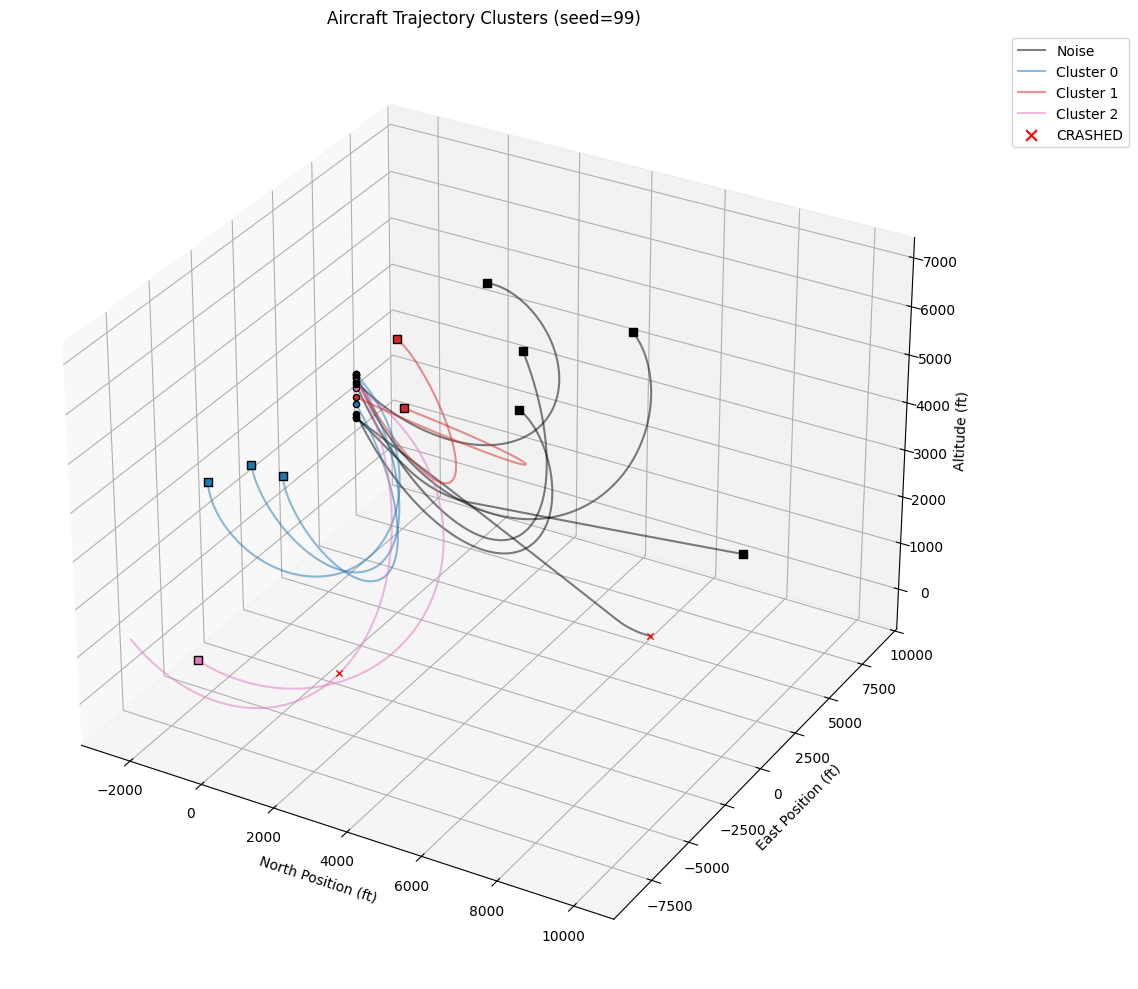

In [180]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

valid_results = [r for r in results if not r.simulation_failed]

plotted_clusters = set()
plotted_noise = False

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # noise points in DBSCAN
        color = "black"
        if not plotted_noise:
            label = "Noise"
            plotted_noise = True
        else:
            label = None
    else:
        color = colors[cluster_id % len(colors)]
        if cluster_id not in plotted_clusters:
            label = f"Cluster {cluster_id}"
            plotted_clusters.add(cluster_id)
        else:
            label = None

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle="-",
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # ax.scatter(
        #     traj[-1, 0],
        #     traj[-1, 1],
        #     traj[-1, 2],
        #     color="red",
        #     s=30,
        #     marker="s",
        #     edgecolor="black",
        #     linewidth=1,
        # )
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )

        # ax.text(
        #     crash_x,
        #     crash_y,
        #     crash_z + 500,
        #     f"{i}",
        #     color="red",
        #     fontsize=10,
        #     fontweight="bold",
        #     ha="center",
        #     va="bottom",
        # )
    else:
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_3d.png")
    print(f"Plot saved to results/{seed}_clusters_3d.png")

2D plots saved to results/99_clusters_2d.png


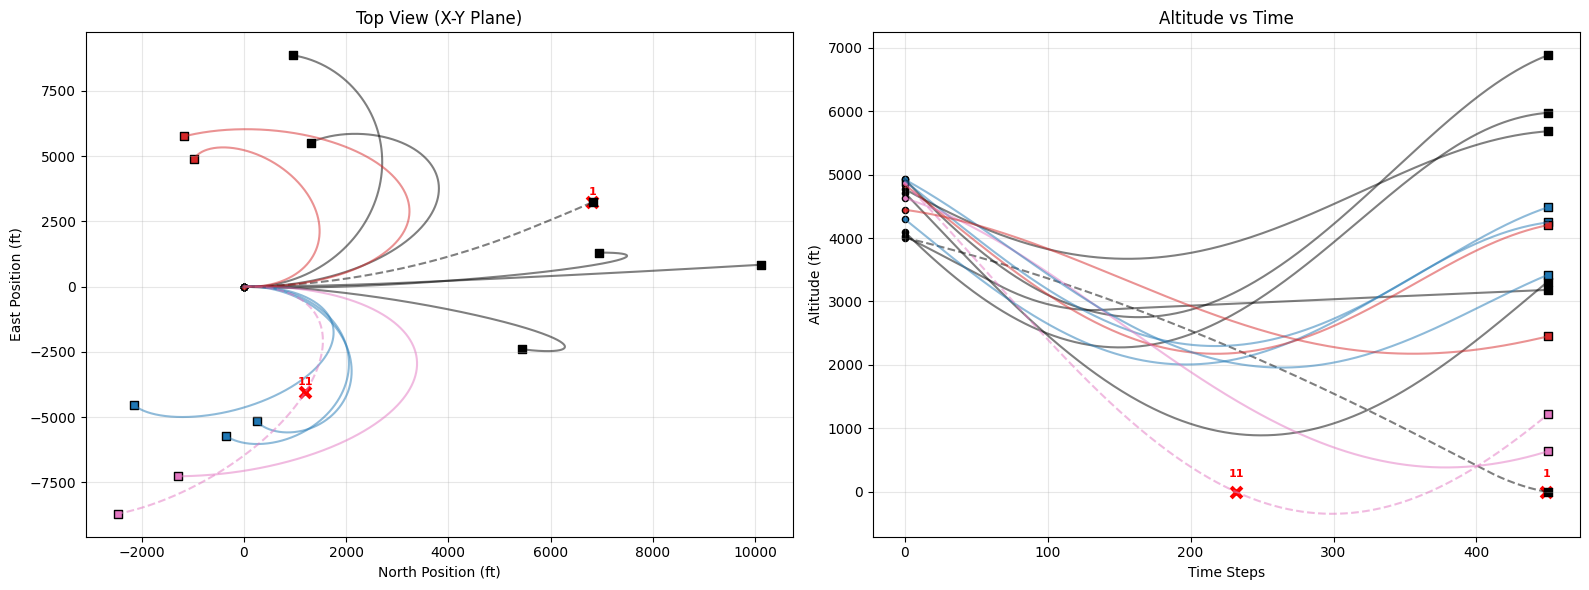

In [181]:
# 2D plotting - x-y plane and altitude vs time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# x-y plane)
ax1 = axes[0]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:
        color = "black"
    else:
        color = colors[cluster_id % len(colors)]

    if result.crashed:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle="--",
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]

        ax1.scatter(
            crash_x,
            crash_y,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax1.text(
            crash_x,
            crash_y + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle="-",
        )

    ax1.scatter(
        traj[0, 0],
        traj[0, 1],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax1.scatter(
        traj[-1, 0],
        traj[-1, 1],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax1.set_xlabel("North Position (ft)")
ax1.set_ylabel("East Position (ft)")
ax1.set_title("Top View (X-Y Plane)")
ax1.grid(True, alpha=0.3)

# altitude vs time
ax2 = axes[1]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:
        color = "black"
    else:
        color = colors[cluster_id % len(colors)]

    time_steps = np.arange(len(traj))

    if result.crashed:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle="--",
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_time = time_steps[crash_idx]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_time = time_steps[min_alt_idx]
            crash_z = traj[min_alt_idx, 2]

        ax2.scatter(
            crash_time,
            crash_z,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax2.text(
            crash_time,
            crash_z + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle="-",
        )

    ax2.scatter(
        0,
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax2.scatter(
        len(traj) - 1,
        traj[-1, 2],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Altitude (ft)")
ax2.set_title("Altitude vs Time")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_2d.png")
    print(f"2D plots saved to results/{seed}_clusters_2d.png")